In [56]:
import os
import os.path

import math

import pandas as pd

import numpy as np

import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute
import sklearn.compose
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

import seaborn as sns

import geopy.geocoders
import geopy.extra.rate_limiter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sklearn.impute.SimpleImputer.get_feature_names_out = (
    lambda self, names=None: self.feature_names_in_
)

In [57]:
df = pd.read_csv(os.path.join(os.getcwd(), 'NH_ProviderInfo_Jan2022_with_coords.csv'))
df.head()

,Unnamed: 0.1,Unnamed: 0,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Total number of nurse staff hours per resident per day on the weekend,Registered Nurse hours per resident per day on the weekend,Reported Physical Therapist Staffing Hours per Resident Per Day,Total nursing staff turnover,Total nursing staff turnover footnote,Registered Nurse turnover,Registered Nurse turnover footnote,Number of administrators who have left the nursing home,Administrator turnover footnote,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date,Full Address,lat,lon
0,0,0,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Corporation,57,53.2,NaN,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",9/1/1969,N,NaN,N,Y,N,Both,Yes,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,1.0,12.0,1.0,12.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8/21/2019,2,2,0,8,1,0,8,8/1/2018,1,1,0,4,1,0,4,6/22/2017,0,0,0,0,0,0,0,5.333,0,0,0.0,1,65

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15238 entries, 0 to 15237
Columns: 101 entries, Unnamed: 0.1 to lon
dtypes: float64(45), int64(32), object(24)
memory usage: 11.7+ MB


In [59]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [60]:
df.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Provider Phone Number,Provider SSA County Code,Provider County Name,Ownership Type,Number of Certified Beds,Average Number of Residents per Day,Average Number of Residents per Day Footnote,Provider Type,Provider Resides in Hospital,Legal Business Name,Date First Approved to Provide Medicare and Medicaid Services,Continuing Care Retirement Community,Special Focus Status,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas,Overall Rating,Overall Rating Footnote,Health Inspection Rating,Health Inspection Rating Footnote,QM Rating,QM Rating Footnote,Long-Stay QM Rating,Long-Stay QM Rating Footnote,Short-Stay QM Rating,Short-Stay QM Rating Footnote,Staffing Rating,Staffing Rating Footnote,RN Staffing Rating,RN Staffing Rating Footnote,Reported Staffing Footnote,Physical Therapist Staffing Footnote,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,Reported RN Staffing Hours per Resident per Day,Reported Licensed Staffing Hours per Resident per Day,Reported Total Nurse Staffing Hours per Resident per Day,Total number of nurse staff hours per resident per day on the weekend,Registered Nurse hours per resident per day on the weekend,Reported Physical Therapist Staffing Hours per Resident Per Day,Total nursing staff turnover,Total nursing staff turnover footnote,Registered Nurse turnover,Registered Nurse turnover footnote,Number of administrators who have left the nursing home,Administrator turnover footnote,Case-Mix Nurse Aide Staffing Hours per Resident per Day,Case-Mix LPN Staffing Hours per Resident per Day,Case-Mix RN Staffing Hours per Resident per Day,Case-Mix Total Nurse Staffing Hours per Resident per Day,Adjusted Nurse Aide Staffing Hours per Resident per Day,Adjusted LPN Staffing Hours per Resident per Day,Adjusted RN Staffing Hours per Resident per Day,Adjusted Total Nurse Staffing Hours per Resident per Day,Rating Cycle 1 Standard Survey Health Date,Rating Cycle 1 Total Number of Health Deficiencies,Rating Cycle 1 Number of Standard Health Deficiencies,Rating Cycle 1 Number of Complaint Health Deficiencies,Rating Cycle 1 Health Deficiency Score,Rating Cycle 1 Number of Health Revisits,Rating Cycle 1 Health Revisit Score,Rating Cycle 1 Total Health Score,Rating Cycle 2 Standard Health Survey Date,Rating Cycle 2 Total Number of Health Deficiencies,Rating Cycle 2 Number of Standard Health Deficiencies,Rating Cycle 2 Number of Complaint Health Deficiencies,Rating Cycle 2 Health Deficiency Score,Rating Cycle 2 Number of Health Revisits,Rating Cycle 2 Health Revisit Score,Rating Cycle 2 Total Health Score,Rating Cycle 3 Standard Health Survey Date,Rating Cycle 3 Total Number of Health Deficiencies,Rating Cycle 3 Number of Standard Health Deficiencies,Rating Cycle 3 Number of Complaint Health Deficiencies,Rating Cycle 3 Health Deficiency Score,Rating Cycle 3 Number of Health Revisits,Rating Cycle 3 Health Revisit Score,Rating Cycle 3 Total Health Score,Total Weighted Health Survey Score,Number of Facility Reported Incidents,Number of Substantiated Complaints,Number of Citations from Infection Control Inspections,Number of Fines,Total Amount of Fines in Dollars,Number of Payment Denials,Total Number of Penalties,Location,Processing Date,Full Address,lat,lon
0,15009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,2563324110,290,Franklin,For profit - Corporation,57,53.2,NaN,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",9/1/1969,N,NaN,N,Y,N,Both,Yes,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,5.0,NaN,1.0,12.0,1.0,12.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,6.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8/21/2019,2,2,0,8,1,0,8,8/1/2018,1,1,0,4,1,0,4,6/22/2017,0,0,0,0,0,0,0,5.333,0,0,0.0,1,650.0,0,1,"701 MONROE STREET N

In [61]:
cat_cols = [
            'Provider City',
            'Provider State',
            'Provider Zip Code',
            'Provider SSA County Code',
            'Ownership Type',
            'Provider Type',
            'Provider Resides in Hospital',
            'Continuing Care Retirement Community',
            'Special Focus Status',
            'Abuse Icon',
            'Most Recent Health Inspection More Than 2 Years Ago',
            'Provider Changed Ownership in Last 12 Months',
            'With a Resident and Family Council',
            'Automatic Sprinkler Systems in All Required Areas',
            'Long-Stay QM Rating Footnote',
            'Short-Stay QM Rating Footnote',
            'Staffing Rating Footnote',
            'RN Staffing Rating Footnote',
            'Reported Staffing Footnote',
            'Physical Therapist Staffing Footnote',
            'Total nursing staff turnover footnote',
            'Registered Nurse turnover footnote',
            'Administrator turnover footnote']

num_cols = ['Number of Certified Beds',
            'Average Number of Residents per Day',
            'Overall Rating',
            'Health Inspection Rating',
            'QM Rating',
            'Long-Stay QM Rating',
            'Short-Stay QM Rating',
            'Staffing Rating',
            'RN Staffing Rating',
            'Reported Nurse Aide Staffing Hours per Resident per Day',
            'Reported LPN Staffing Hours per Resident per Day',
            'Reported RN Staffing Hours per Resident per Day',
            'Reported Licensed Staffing Hours per Resident per Day',
            'Reported Total Nurse Staffing Hours per Resident per Day',
            'Total number of nurse staff hours per resident per day on the weekend',
            'Registered Nurse hours per resident per day on the weekend',
            'Reported Physical Therapist Staffing Hours per Resident Per Day',
            'Total nursing staff turnover',
            'Registered Nurse turnover',
            'Number of administrators who have left the nursing home',
            'Case-Mix Nurse Aide Staffing Hours per Resident per Day',
            'Case-Mix LPN Staffing Hours per Resident per Day',
            'Case-Mix RN Staffing Hours per Resident per Day',
            'Case-Mix Total Nurse Staffing Hours per Resident per Day',
            'Adjusted Nurse Aide Staffing Hours per Resident per Day',
            'Adjusted LPN Staffing Hours per Resident per Day',
            'Adjusted RN Staffing Hours per Resident per Day',
            'Adjusted Total Nurse Staffing Hours per Resident per Day',
            'Rating Cycle 1 Total Number of Health Deficiencies',
            'Rating Cycle 1 Number of Standard Health Deficiencies',
            'Rating Cycle 1 Number of Complaint Health Deficiencies',
            'Rating Cycle 1 Health Deficiency Score',
            'Rating Cycle 1 Number of Health Revisits',
            'Rating Cycle 1 Health Revisit Score',
            'Rating Cycle 1 Total Health Score',
            'Rating Cycle 2 Total Number of Health Deficiencies',
            'Rating Cycle 2 Number of Standard Health Deficiencies',
            'Rating Cycle 2 Number of Complaint Health Deficiencies',
            'Rating Cycle 2 Health Deficiency Score',
            'Rating Cycle 2 Number of Health Revisits',
            'Rating Cycle 2 Health Revisit Score',
            'Rating Cycle 2 Total Health Score',
            'Rating Cycle 3 Total Number of Health Deficiencies',
            'Rating Cycle 3 Number of Standard Health Deficiencies',
            'Rating Cycle 3 Number of Complaint Health Deficiencies',
            'Rating Cycle 3 Health Deficiency Score',
            'Rating Cycle 3 Number of Health Revisits',
            'Rating Cycle 3 Health Revisit Score',
            'Rating Cycle 3 Total Health Score',
            'Total Weighted Health Survey Score',
            'Number of Facility Reported Incidents',
            'Number of Substantiated Complaints',
            'Number of Citations from Infection Control Inspections'
            # 'lat',
            # 'lon'
            ]

target_column = 'Total Amount of Fines in Dollars'

In [64]:
# Make a copy of the data frame to keep the original intact
enhanced_model_df = df.copy()

fine_amount_feature = 'Total Amount of Fines in Dollars'

enhanced_model_df = enhanced_model_df[enhanced_model_df[fine_amount_feature] < enhanced_model_df[fine_amount_feature].quantile(0.99)]
enhanced_model_df = enhanced_model_df[enhanced_model_df[fine_amount_feature] > enhanced_model_df[fine_amount_feature].quantile(0.01)]
enhanced_model_df.shape
df = enhanced_model_df

<AxesSubplot:ylabel='Count'>

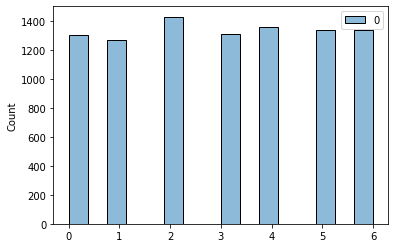

In [76]:
binner = sklearn.compose.ColumnTransformer([
    ("kbins", sklearn.preprocessing.KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile'), [target_column])
])

bins = binner.fit_transform(df)
sns.histplot(bins)

In [77]:
categorical_pipeline = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.OneHotEncoder()
)

numeric_pipeline = sklearn.pipeline.make_pipeline(
    sklearn.impute.SimpleImputer(strategy='median'),
    sklearn.preprocessing.StandardScaler()
)

full_pipeline = sklearn.compose.ColumnTransformer([
    ("categorical", categorical_pipeline, cat_cols),
    ("numeric", numeric_pipeline, num_cols)
])

In [78]:
features_matrix = full_pipeline.fit_transform(df)
features_matrix.shape

(9359, 10770)

In [79]:
training_features, testing_features, training_targets, testing_targets = sklearn.model_selection.train_test_split(features_matrix, df[target_column], test_size=0.25, stratify=bins)

In [80]:
model = sklearn.linear_model.SGDRegressor()
model.fit(training_features, training_targets)

SGDRegressor()

In [81]:
predictions = model.predict(testing_features)

In [82]:
error = math.sqrt(sklearn.metrics.mean_squared_error(testing_targets, predictions))
error

41953.76179157827

In [ ]:
df['Full Address'] = df['Provider Address'] + ", " + df['Provider City'] + ", " + df['Provider State'] + " " + df['Provider Zip Code'].astype(str)
df.head()

In [ ]:
address = df.iloc[0]['Location']

In [ ]:
geolocator = geopy.geocoders.Nominatim(user_agent='jacks-ml-project')
geocode_rate_limited = geopy.extra.rate_limiter.RateLimiter(geolocator.geocode, min_delay_seconds=1)

This next cell takes hours to run, as it calls a web service for each row in the dataset and is rate-limited to 1/sec. This has already been run and is stored in `NH_ProviderInfo_Jan2022_with_coords.csv`. 

In [ ]:
# df['geo_loc'] = df['Full Address'].apply(geocode_rate_limited)
# df['geo_point'] = df['geo_loc'].apply(lambda x: tuple(x.point)[0:2] if x else (np.nan, np.nan))
# df[['lat', 'lon']] = pd.DataFrame(df['geo_point'].tolist(), index=df.index)
# df = df.drop(columns=['geo_loc', 'geo_point'])

In [ ]:
df[df['lat'].isnull()]

Using Bing maps API to fill the values that weren't found by Nominatim.

In [ ]:
missing_coords = df[df['lat'].isnull()]
bing_geolocator = geopy.geocoders.Bing('<API key here>')
bing_geocode_rate_limited = geopy.extra.rate_limiter.RateLimiter(bing_geolocator.geocode, min_delay_seconds=1)

missing_coords['geo_loc'] = missing_coords['Full Address'].apply(bing_geocode_rate_limited)
missing_coords['geo_point'] = missing_coords['geo_loc'].apply(lambda x: tuple(x.point)[0:2] if x else (np.nan, np.nan))
missing_coords[['lat', 'lon']] = pd.DataFrame(missing_coords['geo_point'].tolist(), index=missing_coords.index)
missing_coords = missing_coords.drop(columns=['geo_loc', 'geo_point'])

In [50]:
missing_coords = missing_coords[['Federal Provider Number', 'lat', 'lon']]

In [58]:
df = df.merge(missing_coords, on='Federal Provider Number', how='left')
df['lat'] = df[['lat_x', 'lat_y']].bfill(axis=1).iloc[:,0]
df['lon'] = df[['lon_x', 'lon_y']].bfill(axis=1).iloc[:,0]

In [60]:
df = df.drop(columns=['lat_x', 'lon_x', 'lat_y', 'lon_y'])

In [62]:
df.to_csv('NH_ProviderInfo_Jan2022_with_coords.csv')